In [60]:
import pandas as pd
import numpy as np

In [61]:
X =  pd.read_csv('C:/Users/stat_pc/Desktop/深度學習/HW1/X_train.csv')
y = pd.read_csv('C:/Users/stat_pc/Desktop/深度學習/HW1/y_train.csv')
y = y.values.ravel()
testdata = pd.read_csv('C:/Users/stat_pc/Desktop/深度學習/HW1/X_test.csv')

In [62]:
print(X.shape)
print(X.columns)

(85751, 8)
Index(['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST'],
      dtype='object')


In [63]:
X.head()

,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
0,1,358,2.4,0,3.2,20.6,2,4.5
1,1,585,8.3,0,1.2,3.0,2,0.5
2,1,540,19.9,0,0.6,3.5,2,3.2
3,1,392,9.0,0,0.9,21.1,2,4.9
4,3,401,22.7,0,0.7,4.1,2,2.9


# 由於'PERIOD'和'PTS_TYPE'應為類別變數，故將這兩項變數用one hot encoding轉換

In [64]:
df2 = pd.get_dummies(X['PTS_TYPE'])
df2.columns = ['2 point','3 point']
df3 = pd.get_dummies(X['PERIOD'])
df3.columns = ['period 1','period 2','period 3','period 4','period 5','period 6','period 7']
newX = pd.concat([X[['GAME_CLOCK','SHOT_DIST','TOUCH_TIME','SHOT_CLOCK','DRIBBLES','CLOSE_DEF_DIST']],df2],axis=1)
newX = pd.concat([newX,df3],axis=1)
newX.head()

,GAME_CLOCK,SHOT_DIST,TOUCH_TIME,SHOT_CLOCK,DRIBBLES,CLOSE_DEF_DIST,2 point,3 point,period 1,period 2,period 3,period 4,period 5,period 6,period 7
0,358,20.6,3.2,2.4,0,4.5,1,0,1,0,0,0,0,0,0
1,585,3.0,1.2,8.3,0,0.5,1,0,1,0,0,0,0,0,0
2,540,3.5,0.6,19.9,0,3.2,1,0,1,0,0,0,0,0,0
3,392,21.1,0.9,9.0,0,4.9,1,0,1,0,0,0,0,0,0
4,401,4.1,0.7,22.7,0,2.9,1,0,0,0,1,0,0,0,0


# 將data切成training data 和 validation data

In [65]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error,precision_score,accuracy_score
from sklearn.model_selection import train_test_split,KFold
#from sklearn.cross_validation import KFold, train_test_split
from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import GridSearchCV
import math
from sklearn.preprocessing import StandardScaler

In [66]:
X_train, X_test, y_train, y_test = train_test_split(newX,y,test_size=0.3,random_state=0)

# 建模

## Naive Bayes  
accuracy低於0.6

In [8]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()

classifier.fit(X_train, y_train)

# Predicting the Test set results

pred = classifier.predict(X_test)

print('accuracy')
print(accuracy_score(y_test, pred))

accuracy
0.5382103708310658


## RidgeClassifier
accuracy=0.6080230117390967

In [9]:
from sklearn.linear_model import RidgeClassifier
clf = RidgeClassifier().fit(X_train, y_train)
pred = clf.predict(X_test)
print('accuracy')
print(accuracy_score(y_test, pred))

accuracy
0.6080230117390967


## SVM
accuracy低於0.6

In [13]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
print('accuracy')
print(accuracy_score(y_test, pred))

accuracy
0.5972556946280028


## Xgboost(稱 XGBmodel1)
accuracy = 0.6133872347041903,表現比前述的model好一點

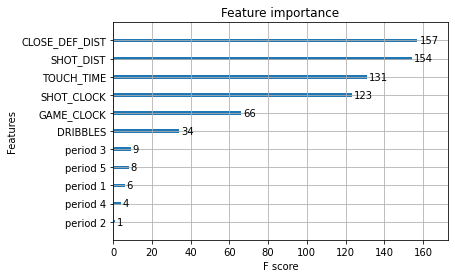

confusion_matrix
[[11835  2094]
 [ 7852  3945]]
accuarcy
0.6133872347041903


In [17]:
# Boosting without parameter tuning
xgb_model = XGBClassifier().fit(X_train,y_train)

pred = xgb_model.predict(X_test)

plot_importance(xgb_model, importance_type ='weight')
pyplot.show()

print('confusion_matrix')
print(confusion_matrix(y_test, pred))
print('accuarcy')
print(accuracy_score(y_test, pred))

## 接下來我嘗試用 GridSearchCV 去 tune Xgboost 參數，找出較好的model(稱 XGBmodel2)，發現accuarcy=0.613853688875068 比XGBmodel1好一點點

In [11]:
parameters_for_testing = {
    'subsample':[0.5,1],
    'colsample_bytree':[0.5,1],
    'min_child_weight':[0.00001,0.0001,0.001,0.01,0.1],
    'learning_rate':[0.00001,0.0001,0.001],
    'n_estimators':[1,5,10,30,50,100],
    'max_depth':[3,5,8,10,12,15],
    'random_state':[0]
}

xgb_model1 = XGBClassifier()

Grid = GridSearchCV(estimator = xgb_model1, param_grid = parameters_for_testing, scoring='accuracy',verbose=2,n_jobs=-1)
Grid.fit(X_train,y_train)

pred = Grid.predict(X_test)

print('confusion_matrix')
print(confusion_matrix(y_test, pred))
print('accuarcy')
print(accuracy_score(y_test, pred))
print('best params')
print (Grid.best_params_)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

confusion_matrix
[[11935  1994]
 [ 7940  3857]]
accuarcy
0.613853688875068
best params
{'colsample_bytree': 1, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 1e-05, 'n_estimators': 50, 'random_state': 0, 'subsample': 0.5}


## 我以XGBmodel2的參數為基礎，而以Model complexity (max_depth)當x軸，error=1- accuracy當y軸畫error curve，可發現training error整體而言呈下降趨勢，當max_depth達到8時，testing error達到最低點，而後有些微上升的趨勢，可認為當max_depth大於8時，有overfitting的情況發生

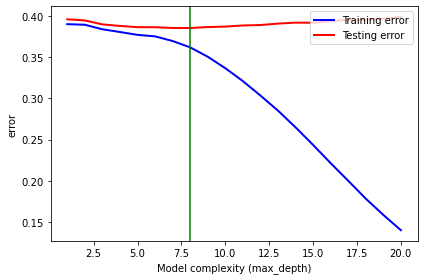

In [55]:
error_train = []
error_test = []


for d in range(1, 21):
    XGB =XGBClassifier(
    colsample_bytree =1,
    learning_rate= 0.001,
    max_depth= d,
    min_child_weight=1e-05,
    n_estimators =50,
    random_state = 0,
    subsample = 0.5)
    XGB.fit(X_train,y_train)
    y_train_pred = XGB.predict(X_train)
    y_test_pred = XGB.predict(X_test)
    error_train.append(1-accuracy_score(y_train, y_train_pred))
    error_test.append(1-accuracy_score(y_test, y_test_pred))

plt.plot(range(1, 21), error_train, label = 'Training error', color = 'blue', linewidth = 2)
plt.plot(range(1, 21), error_test, label = 'Testing error', color = 'red', linewidth = 2)
plt.legend(loc='upper right')
plt.xlabel('Model complexity (max_depth)')
plt.ylabel('error')
plt.axvline(x=error_test.index(min(error_test))+1,ls="-",c="green")
plt.tight_layout()
plt.savefig('./output/fig-error-curve.png', dpi=300)
plt.show()

## 將max_depth改成8，其餘XGBmodel2的參數不變，重新fit model(稱XGBmodel3)，得到accuarcy=0.6148643395786364，為目前最高的accuarcy，因此XGBmodel3即是本次我認為最好的model。另外觀察XGBmodel3的Feature importance，我們得到前三重要的Feature為"GAME_CLOCK"、"SHOT_CLOCK"、"SHOT_DIST"

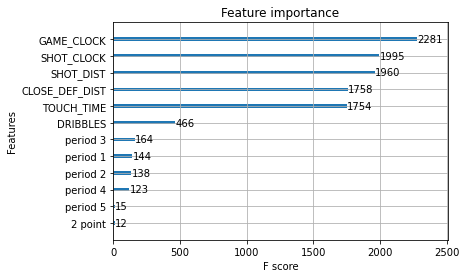

confusion_matrix
[[11840  2089]
 [ 7819  3978]]
accuarcy
0.6148643395786364


In [67]:
finalXGB =XGBClassifier(
    colsample_bytree =1,
    learning_rate= 0.001,
    max_depth= 8  ,
    min_child_weight=1e-05,
    n_estimators =50,
    random_state = 0,
    subsample = 0.5)
finalXGB.fit(X_train,y_train)
pred = finalXGB.predict(X_test)

plot_importance(finalXGB, importance_type ='weight')
pyplot.show()

print('confusion_matrix')
print(confusion_matrix(y_test, pred))
print('accuarcy')
print(accuracy_score(y_test, pred))


## 用"GAME_CLOCK"、"SHOT_CLOCK"、"SHOT_DIST"，這3個Feature重新去fit Xgboost，得到accuarcy = 0.6053409002565497

In [44]:
top3feature = newX[['GAME_CLOCK','SHOT_CLOCK','SHOT_DIST']]
X_train1, X_test1, y_train1, y_test1 = train_test_split(top3feature,y,test_size=0.3,random_state=0)
XGB =XGBClassifier(
    colsample_bytree =1,
    learning_rate= 0.001,
    max_depth= 8,
    min_child_weight=1e-05,
    n_estimators =50,
    random_state = 0,
    subsample = 0.5)
XGB.fit(X_train1,y_train1)
pred = XGB.predict(X_test1)

print('confusion_matrix')
print(confusion_matrix(y_test1, pred))
print('accuarcy')
print(accuracy_score(y_test1, pred))

confusion_matrix
[[11368  2561]
 [ 7592  4205]]
accuarcy
0.6053409002565497


## 輸出csv檔

In [70]:
testdata = pd.read_csv('C:/Users/stat_pc/Desktop/深度學習/HW1/X_test.csv')
df2 = pd.get_dummies(testdata['PTS_TYPE'])
df2.columns = ['2 point','3 point']
df3 = pd.get_dummies(testdata['PERIOD'])
df3.columns = ['period 1','period 2','period 3','period 4','period 5','period 6','period 7']
testnewX = pd.concat([testdata[['GAME_CLOCK','SHOT_DIST','TOUCH_TIME','SHOT_CLOCK','DRIBBLES','CLOSE_DEF_DIST']],df2],axis=1)
testnewX = pd.concat([testnewX,df3],axis=1)

finalpred = finalXGB.predict(testnewX)
pd.DataFrame(finalpred).to_csv('C:/Users/stat_pc/Desktop/深度學習/HW1/y_pred.csv',index=False,header=False)